# ISDS 558 Spring 2024
# Group 05
### Web Scraping and Data Visualization for Sports Analytics (NBA Data)

# Web Scraping

In [ ]:
# Importing required packages

# Generic
import pandas as pd
import re
import numpy as np

# Web Scraping
import requests
from bs4 import BeautifulSoup

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Linear Regression
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas


In [ ]:
def scrape_nba_stats(url, id):
    try:
        # Send a GET request to the URL
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an exception for 4xx or 5xx status codes

        # Create a BeautifulSoup object to parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the table with class 'stats_table' and mentioned id
        table = soup.find('table', class_='stats_table', id = id)

        # Throw error if table element not found
        if table is None:
            print("Error: Table not found on the page.")
            return None

        # Extract the headers from the table
        headers = []
        header_row = table.find('thead').find_all('tr')[-1] # Get the last header row
        for th in header_row.find_all('th')[:]:  # Skip the first empty header
            headers.append(th.text)

        # Extract the rows from the table
        rows = []
        for row in table.find('tbody').find_all('tr'):
            row_data = []
            for th in row.find_all('th'):
                th_text = th.text
                match = re.search(r'[^a-zA-Z0-9\s]', th_text)
                if match:
                  # If a special character is found, return the substring before it
                  row_data.append(th_text[:match.start()].strip())
                else:
                  # If no special character is found, return the original string
                  row_data.append(th_text)
            for td in row.find_all('td'):
                td_text = td.text
                try:
                  # Try to convert the string to a float
                  float(td_text)
                  # If successful, append the original string
                  row_data.append(td_text)
                except:
                  match = re.search(r'[^a-zA-Z0-9\s]', td_text)
                  if match:
                    # If a special character is found, return the substring before it
                    row_data.append(td_text[:match.start()].strip())
                  else:
                    # If no special character is found, return the original string
                    row_data.append(td_text)

            if len(row_data) == len(headers):
                rows.append(row_data)
            else:
                # Handle missing or extra columns
                if len(row_data) < len(headers):
                    # Add missing values
                    row_data.extend([''] * (len(headers) - len(row_data)))
                else:
                    # Remove extra columns
                    row_data = row_data[:len(headers)]
                rows.append(row_data)

        # Create a DataFrame from the extracted data
        df = pd.DataFrame(rows, columns=headers)

        # Drop rows where all values are empty strings
        df = df.loc[~(df == '').all(axis=1)]

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# URL of the page to scrape train data
url_train = 'https://www.basketball-reference.com/leagues/NBA_2023.html'

# Scrape the NBA game stats

# id for tables to be extracted
east_conf_win = 'confs_standings_E'
west_conf_win = 'confs_standings_W'
overall_stats = 'per_game-team'

# Extracting tables
east_win_train = scrape_nba_stats(url_train, east_conf_win)
west_win_train = scrape_nba_stats(url_train, west_conf_win)
overall_stats_train = scrape_nba_stats(url_train, overall_stats)

In [ ]:
# URL of the page to scrape test data
url_test = 'https://www.basketball-reference.com/leagues/NBA_2024.html'

# Scrape the NBA game stats

# Extracting tables
east_win_test = scrape_nba_stats(url_test, east_conf_win)
west_win_test = scrape_nba_stats(url_test, west_conf_win)
overall_stats_test = scrape_nba_stats(url_test, overall_stats)

In [ ]:
# Reading player stats for train data from excel
player_stats_train = pd.read_excel('Team_Player_Stats_Train_2022_23.xlsx')

# Reading player stats for test data from excel
player_stats_test = pd.read_excel('Team_Player_Stats_Test_2023_24.xlsx')

# Data cleaning

In [ ]:
def data_clean(win1, win2, overall, player):
  # Appending Eastern and Western conference standings table after changing few column names
  win1 = win1.rename(columns = {"Eastern Conference" : "Team", "W/L%" : "Win_Percent"})
  win2 = win2.rename(columns = {"Western Conference" : "Team", "W/L%" : "Win_Percent"})
  standing_df = pd.concat([win1, win2])
  standing_df = standing_df[['Team', 'Win_Percent']]

  # Renaming columns in game stats dataframe
  overall = overall.rename(columns = {"FG%" : "FG_Percent", "3P" : "Three_PointFG", "3PA" : "Three_PointAssist", "3P%" : "Three_PointFG__Percent",
                                                        "2P" : "Two_PointFG", "2PA" : "Two_PointAssist", "2P%" : "Two_PointFG__Percent", "FT%" : "FT_Percent"})

  # Merging the Conference Standings, Overall Statistics, and player statistics dataframes
  # to get the win percent from the conference standings and player stats from the player statistics dataframe on 'Team' column
  stats_player = pd.merge(overall, player, on = 'Team')
  stats = pd.merge(standing_df, stats_player, on = 'Team')

  # Converting relevant columns to numeric and handling invalid parsing error
  for col in stats.columns[1:].tolist():
      stats[col] = pd.to_numeric(stats[col], errors='coerce')

  # Convert categorical columns
  # Assuming 'Team' should be categorical
  stats['Team'] = stats['Team'].astype('category')
  return(stats)


In [ ]:
# Storing cleaned train data
train_stats = data_clean(east_win_train, west_win_train, overall_stats_train, player_stats_train)

# Storing cleaned test data
test_stats = data_clean(east_win_test, west_win_test, overall_stats_test, player_stats_test)

# Looking at train data
train_stats.head()

,Team,Win_Percent,Rk,G,MP,FG,FGA,FG_Percent,Three_PointFG,Three_PointAssist,...,AST,STL,BLK,TOV,PF,PTS,Height,Weight,Age,Experience
0,Milwaukee Bucks,0.707,9,82,241.8,42.7,90.4,0.473,14.8,40.3,...,25.8,6.4,4.9,14.6,18.1,116.9,199.6,97.3,27.9,7.2
1,Boston Celtics,0.695,4,82,243.7,42.2,88.8,0.475,16.0,42.6,...,26.7,6.4,5.2,13.4,18.8,117.9,201.2,98.2,25.9,5.8
2,Philadelphia 76ers,0.659,14,82,242.4,40.8,83.8,0.487,12.6,32.6,...,25.2,7.7,4.7,13.7,20.4,115.2,198.9,101.4,27.1,5.1
3,Cleveland Cavaliers,0.622,25,82,242.4,41.6,85.2,0.488,11.6,31.6,...,24.9,7.1,4.7,13.3,19.0,112.3,198.4,99.1,26.2,5.1
4,New York Knicks,0.573,11,82,243.4,42.0,89.4,0.470,12.6,35.7,...,22.9,6.4,4.1,13.0,20.3,116.0,197.4,95.7,26.1,3.9


# Data visualization

##Variable Glossary

###Game Stats (All stats are the team wise average for the season) -
* MP - Minutes played
* FG - Field goals
* FGA - Field goal assists
* FG_Percent - Field goal scored / (field goals scored + field goal assisted)
* Three_PointFG - 3 point field goal
* Three_PointAssist - 3 point field goal assists
* Three_PointFG__Percent - 3 point field goals scored / (3 point field goals scored + 3 point field goals assisted)
* Two_PointFG - 2 point field goal
* Two_PointAssist - 2 point field goal assists
* Two_PointFG__Percent - 2 point field goals scored / (2 point field goals scored + 2 point field goals assisted)
* FT - Free throws
* FTA - Free throw assists
* FT_Percent - Free throws / (free throws + free throw assists)
* ORB - Offensive rebounds
* DRB - Defensive rebounds
* TRB - Total rebounds
* AST - Total assists
* STL - Total steals
* BLK - Total blocks
* TOV - Total turnovers
* PF - Total personal fouls
* PTS - Total points


### Player Stats (All stats are the teaam wise average for the season) -
* Height - Height of all players
* Weight - Weight of all players
* Age - Age of all players
* Experience - Number of years of playing experience

In [77]:
# Correlation matrix for the numeric columns
train_stats.iloc[:, 4:].corr()

0.8770359531854094

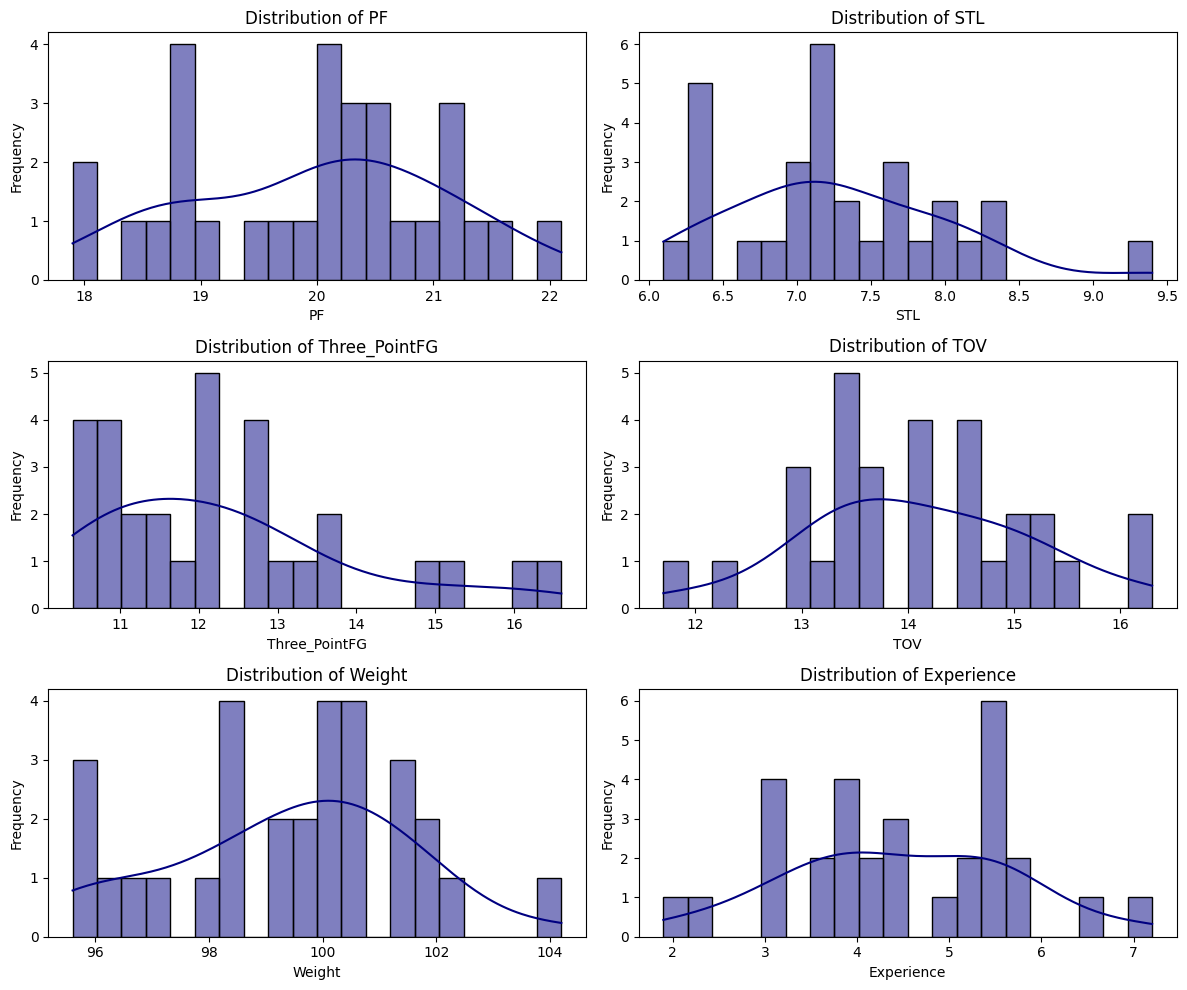

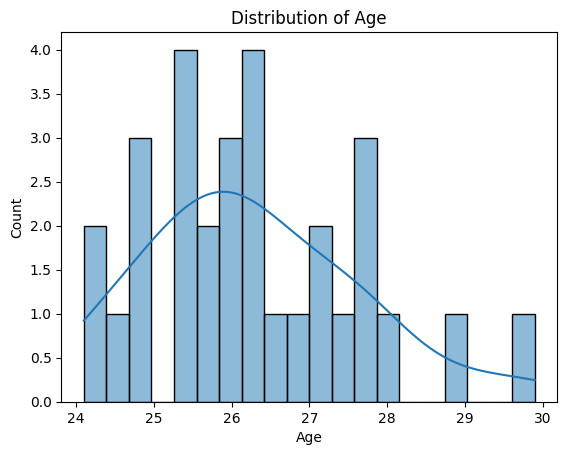

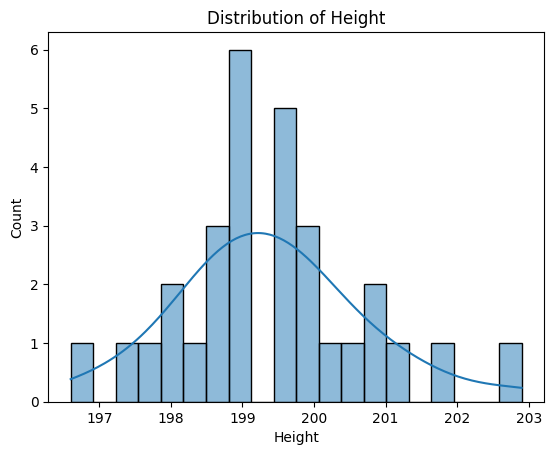

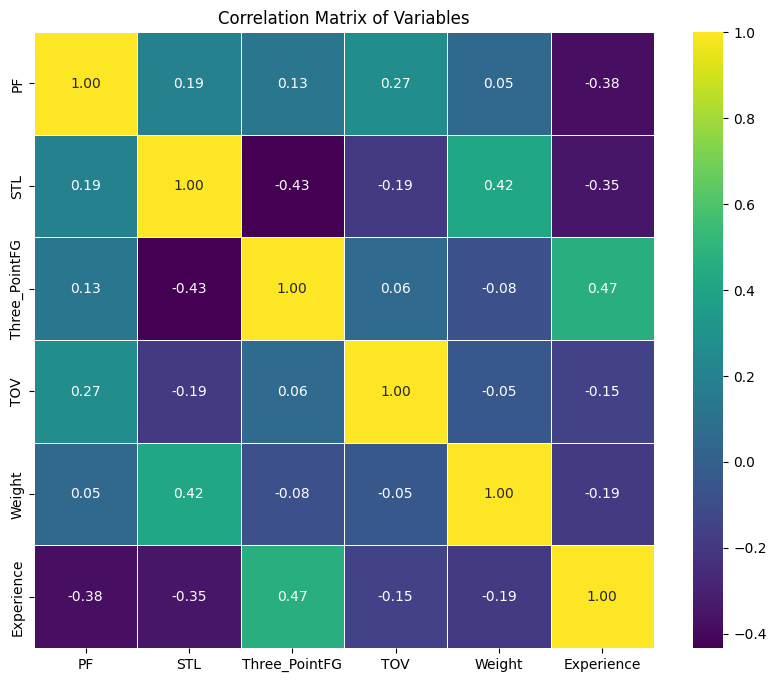

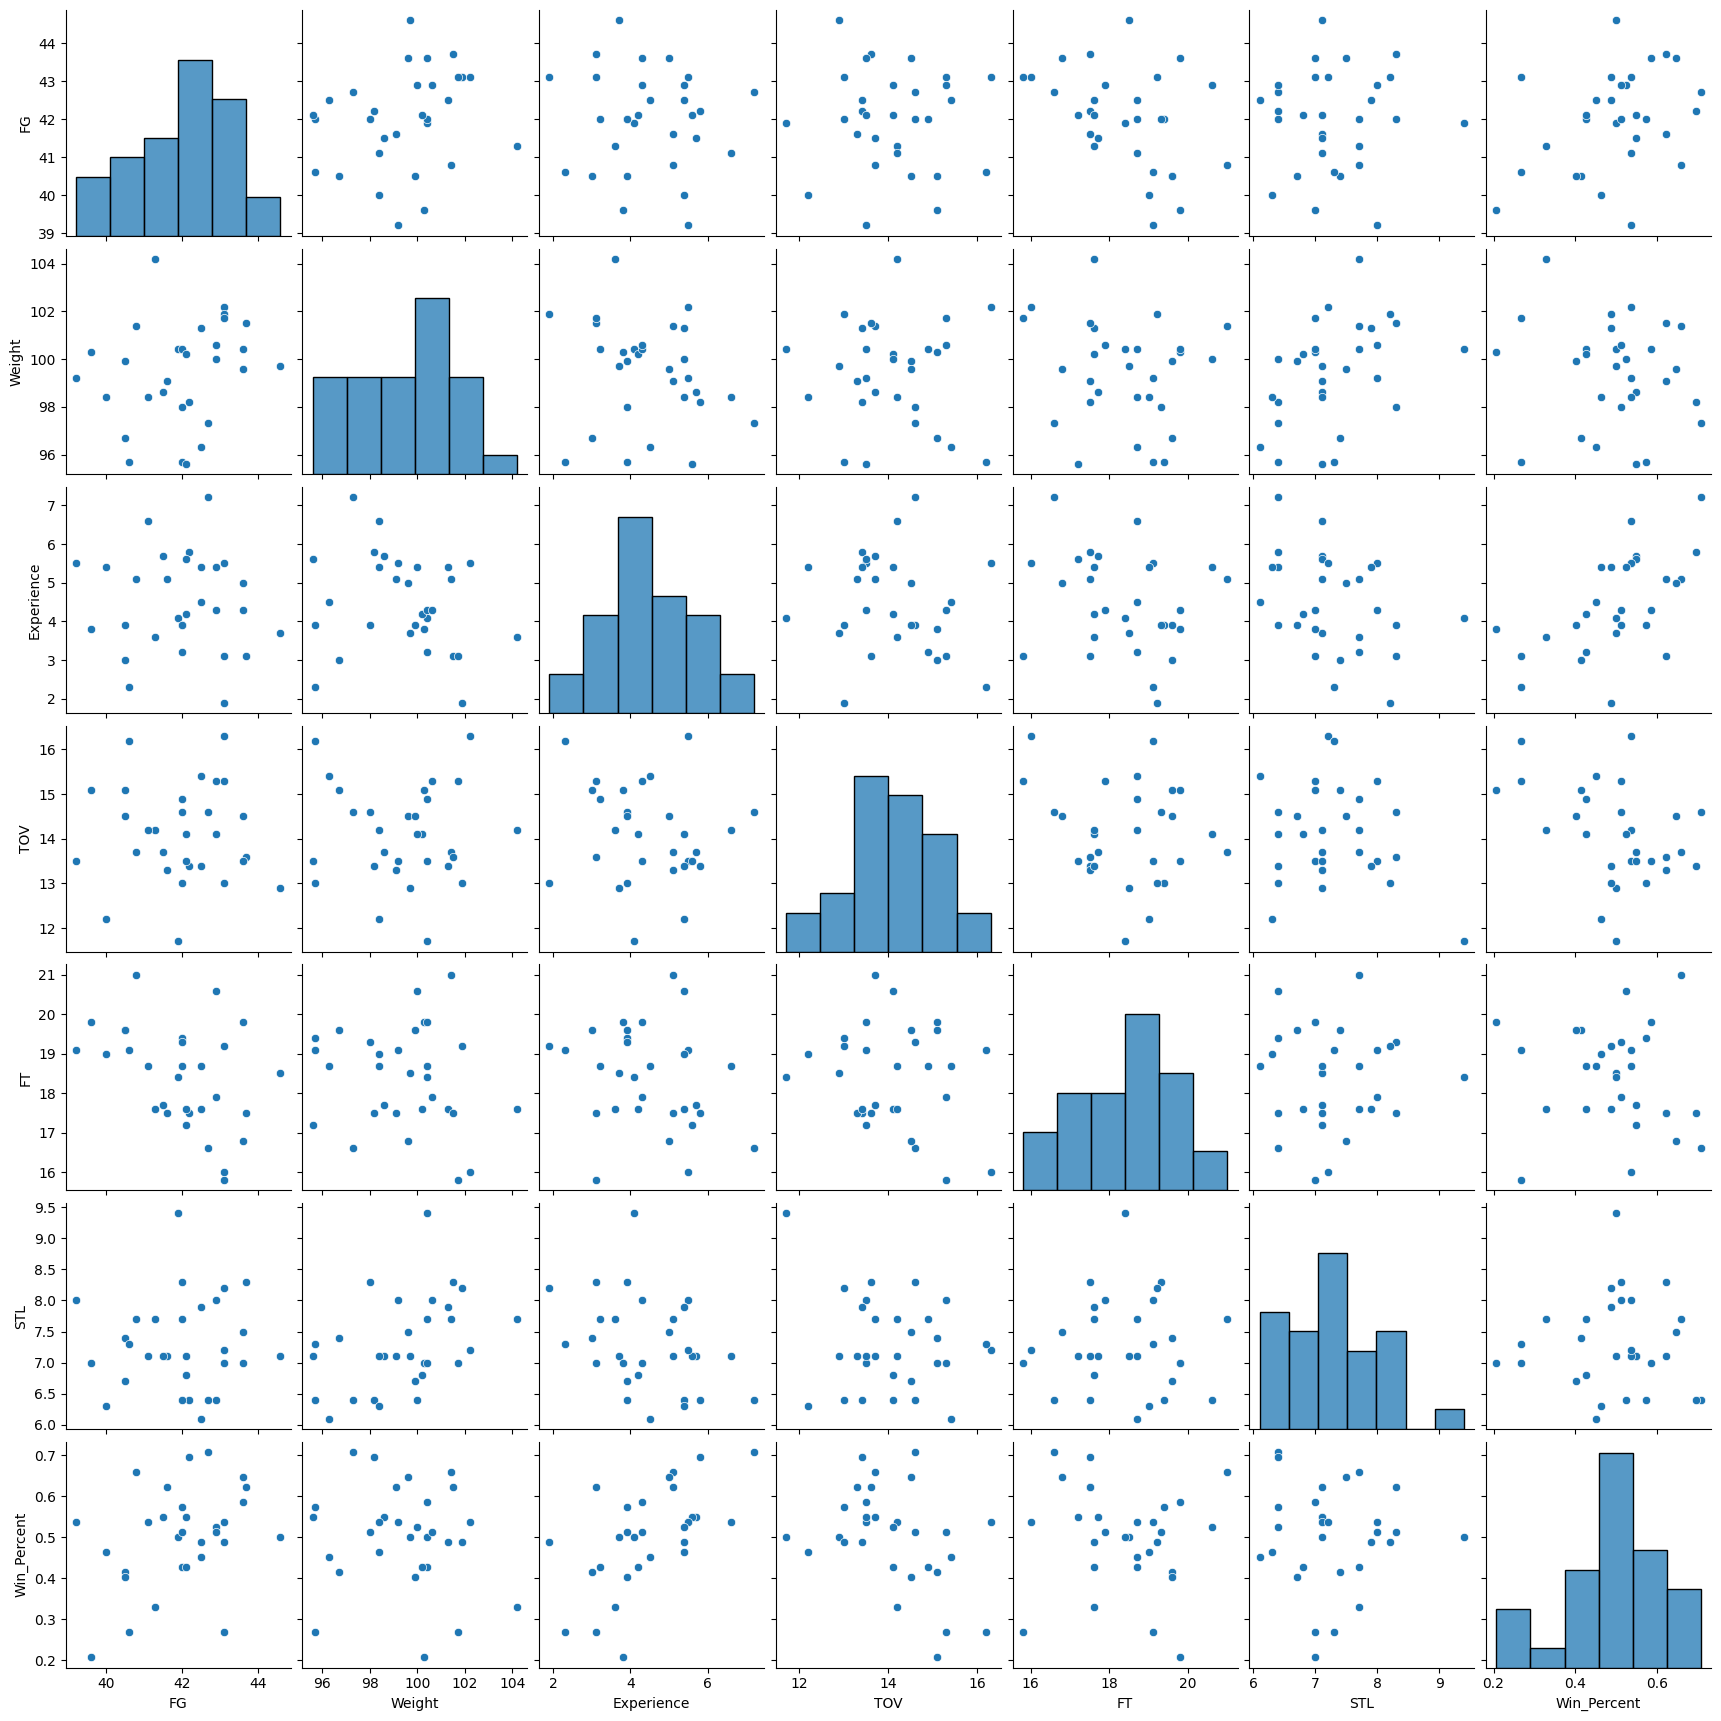

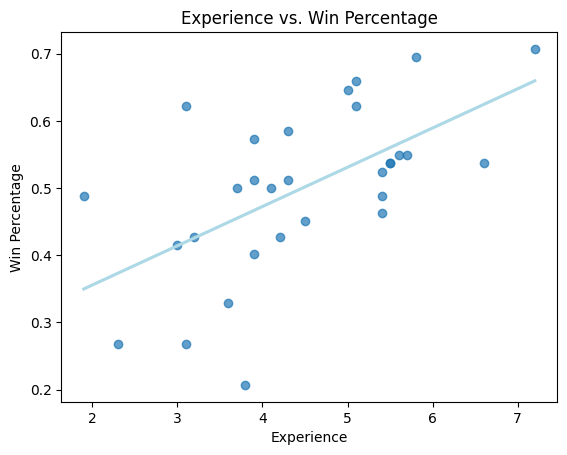

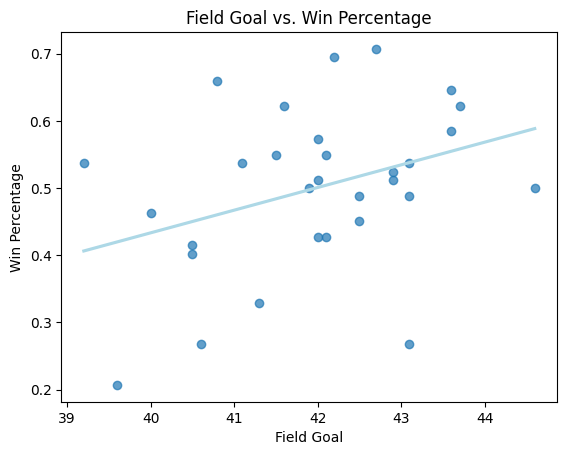

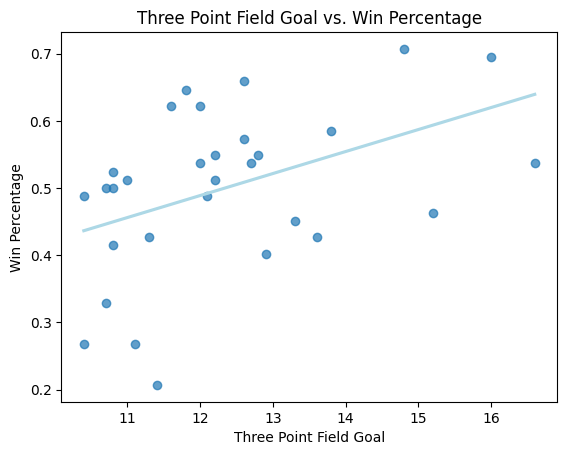

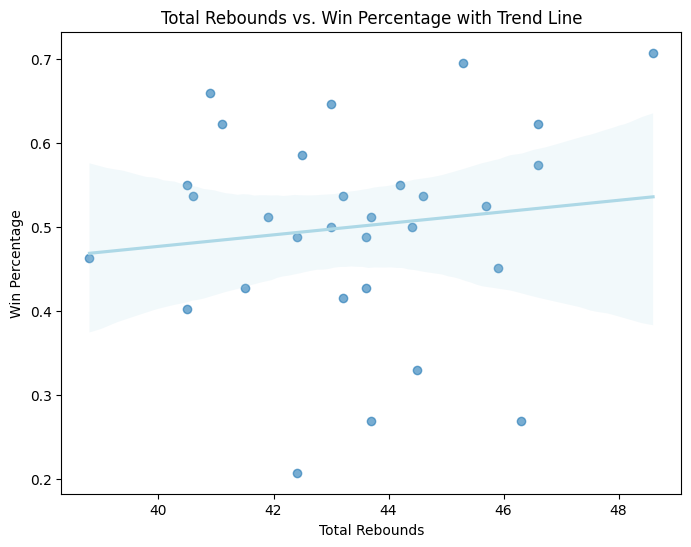

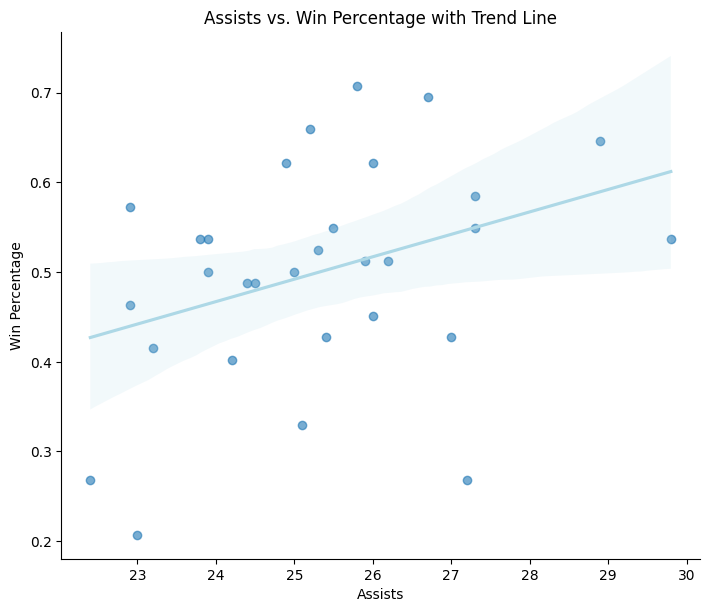

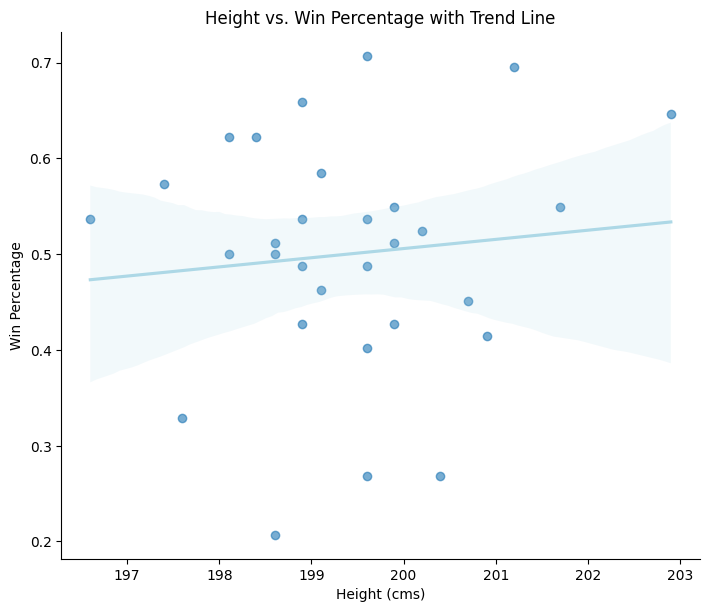

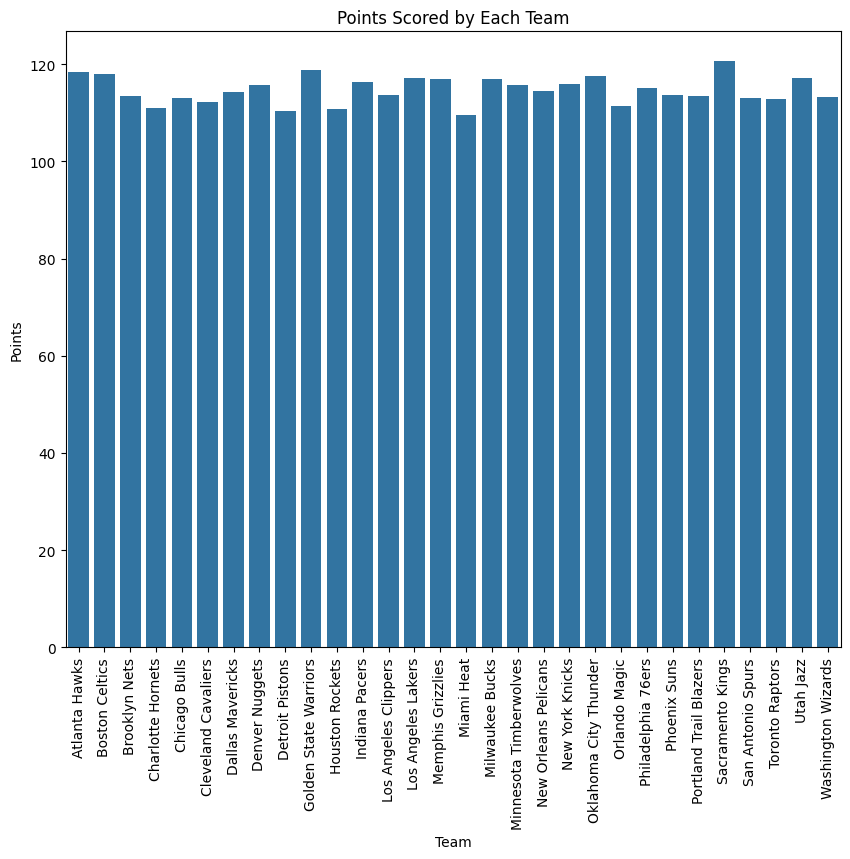

In [132]:
#2
# Pairplot for pairwise comparisons of numerical variables
#sns.pairplot(train_stats, vars = ["MP", "FG", "FGA", "FG_Percent", "Three_PointFG", "Three_PointAssist", "Three_PointFG_Percent", "Two_PointFG", "Two_PointAssist", "Two_PointFG_Percent", "FT", "FTA", "FT_Percent", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Height", "Weight", "Age", "Experience"], palette='viridis')
#plt.suptitle('Pairwise Relationships of Numerical Variables', y = 1.02)
#plt.show()
#print("\n")

# Define the variables you want to create histograms for
variables = ['PF', 'STL', 'Three_PointFG', 'TOV', 'Weight', 'Experience']

# Create histograms for each variable
plt.figure(figsize=(12, 10))
for i, variable in enumerate(variables, 1):
    # Create a subplot for each variable
    plt.subplot(3, 2, i)

    # Create a histogram for the variable using seaborn
    sns.histplot(train_stats[variable], kde=True, bins=20, color='#000080')

    # Add a title and labels
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()
#3
# Distribution of age using histogram
sns.histplot(train_stats['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()
print("\n")

#3
# Distribution of height using histogram
sns.histplot(train_stats['Height'], bins=20, kde=True)
plt.title('Distribution of Height')
plt.xlabel('Height')
plt.show()
print("\n")

#4
#variables = ['FG', 'FT', 'TOV', 'STL', 'Weight', 'Experience']

# Loop through each variable and create bar plots
#for variable in variables:
    # Create a bar plot
   # plt.figure(figsize=(8, 6))
    #sns.barplot(x=train_stats[variable], y=train_stats['Win_Percent'])
    #plt.title(f'Bar Plot of Win Percent vs. {variable}')
    #plt.xlabel(variable)
    #plt.ylabel('Win Percent')
    #plt.show()

#5
#Correlation
variables = ['PF', 'STL', 'Three_PointFG', 'TOV', 'Weight', 'Experience']
correlation_matrix = train_stats[variables].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()


#pairplot
variables = ['FG', 'Weight', 'Experience', 'TOV', 'FT', 'STL','Win_Percent']

# Create a pairplot
sns.pairplot(train_stats[variables], kind='scatter')

# Show the pairplot
plt.show()

#6
# Scatter plot
# Create a scatter plot and add a linear regression trend line without the shaded area
sns.regplot(data=train_stats, x='Experience', y='Win_Percent', ci=None, line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.7})

# Add labels and title
plt.xlabel('Experience')
plt.ylabel('Win Percentage')
plt.title('Experience vs. Win Percentage')

# Show the plot
plt.show()

#7
# Scatter plot
# Create a scatter plot and add a linear regression trend line without the shaded area
sns.regplot(data=train_stats, x='FG', y='Win_Percent', ci=None, line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.7})

# Add labels and title
plt.xlabel('Field Goal')
plt.ylabel('Win Percentage')
plt.title('Field Goal vs. Win Percentage')
# Show the plot
plt.show()

#8
# Scatter plot
# Create a scatter plot and add a linear regression trend line without the shaded area
sns.regplot(data=train_stats, x='Three_PointFG', y='Win_Percent', ci=None, line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.7})

# Add labels and title
plt.xlabel('Three Point Field Goal')
plt.ylabel('Win Percentage')
plt.title('Three Point Field Goal vs. Win Percentage')

# Show the plot
plt.show()

#9
#Scatter plot for TRB vs Win_Percent
# Create a scatter plot with a linear regression line for total rebounds vs. win percentage
plt.figure(figsize=(8, 6))
sns.regplot(data=train_stats, x='TRB', y='Win_Percent', line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.6})

# Add labels and title
plt.xlabel('Total Rebounds')
plt.ylabel('Win Percentage')
plt.title('Total Rebounds vs. Win Percentage with Trend Line')

# Show the plot
plt.show()

#10

# Create a scatter plot with a linear regression line for assists vs. win percentage
sns.lmplot(data=train_stats, x='AST', y='Win_Percent', height=6, aspect=1.2, line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.6})

# Customize plot appearance
plt.xlabel('Assists')
plt.ylabel('Win Percentage')
plt.title('Assists vs. Win Percentage with Trend Line')

# Show the plot
plt.show()

#11

# Create a scatter plot with a linear regression line for height vs. win percentage
sns.lmplot(data=train_stats, x='Height', y='Win_Percent', height=6, aspect=1.2, line_kws={'color': 'lightblue'}, scatter_kws={'alpha': 0.6})

# Customize plot appearance
plt.xlabel('Height (cms)')
plt.ylabel('Win Percentage')
plt.title('Height vs. Win Percentage with Trend Line')

# Show the plot
plt.show()

#12
# Create a bar plot for teams and points
plt.figure(figsize=(10, 8))
sns.barplot(data=train_stats, x='Team', y='PTS')

# Add labels and title
plt.xlabel('Team')
plt.ylabel('Points')
plt.title('Points Scored by Each Team')

# Rotate x-axis labels for better readability if there are many teams
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Linear regression models

## Training the model

In [92]:
# Train model with game stats variables
lm1 = smf.ols(formula='Win_Percent ~ FG + FGA + Three_PointFG + Three_PointAssist + FT + FTA + STL + BLK + TOV + PF',
              data = train_stats)
result1 = lm1.fit()
result1.params

Intercept            0.194262
FG                   0.017861
FGA                 -0.002292
Three_PointFG        0.135419
Three_PointAssist   -0.038218
FT                  -0.005489
FTA                  0.019424
STL                  0.054167
BLK                  0.030045
TOV                 -0.022879
PF                  -0.058732
dtype: float64

In [93]:
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:            Win_Percent   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     7.298
Date:                Thu, 09 May 2024   Prob (F-statistic):           0.000116
Time:                        02:26:37   Log-Likelihood:                 44.633
No. Observations:                  30   AIC:                            -67.27
Df Residuals:                      19   BIC:                            -51.85
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1943      0.75

In [95]:
# Train model with game stats variables
lm2 = smf.ols(formula='Win_Percent ~ PF + STL + Three_PointFG',
              data = train_stats)
result2 = lm2.fit()
result2.params

Intercept        0.708561
PF              -0.065427
STL              0.064452
Three_PointFG    0.050973
dtype: float64

In [96]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:            Win_Percent   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     10.19
Date:                Thu, 09 May 2024   Prob (F-statistic):           0.000129
Time:                        02:27:47   Log-Likelihood:                 32.636
No. Observations:                  30   AIC:                            -57.27
Df Residuals:                      26   BIC:                            -51.67
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7086      0.351      2.019

In [105]:
# Train model with player stats variables
lm3 = smf.ols(formula='Win_Percent ~ Experience + Weight + Age + Height',
              data = train_stats)
result3 = lm3.fit()
result3.params

Intercept     0.324750
Experience    0.065470
Weight       -0.001493
Age          -0.009580
Height        0.001418
dtype: float64

In [106]:
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:            Win_Percent   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     3.425
Date:                Thu, 09 May 2024   Prob (F-statistic):             0.0230
Time:                        02:29:12   Log-Likelihood:                 27.530
No. Observations:                  30   AIC:                            -45.06
Df Residuals:                      25   BIC:                            -38.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3247      3.772      0.086      0.9

In [107]:
# Train model with player stats variables
lm4 = smf.ols(formula='Win_Percent ~ Experience',
              data = train_stats)
result4 = lm4.fit()
result4.params

Intercept     0.238863
Experience    0.058412
dtype: float64

In [108]:
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:            Win_Percent   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     14.93
Date:                Thu, 09 May 2024   Prob (F-statistic):           0.000604
Time:                        02:29:50   Log-Likelihood:                 27.387
No. Observations:                  30   AIC:                            -50.77
Df Residuals:                      28   BIC:                            -47.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2389      0.070      3.411      0.0

In [122]:
# Final train model with overall stats variables
lm5 = smf.ols(formula='Win_Percent ~ PF + STL + Three_PointFG + TOV + Weight + Experience',
              data = train_stats)
result5 = lm5.fit()
result5.params

Intercept        1.846141
PF              -0.047076
STL              0.073992
Three_PointFG    0.042011
TOV             -0.022655
Weight          -0.012614
Experience       0.024692
dtype: float64

In [123]:
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:            Win_Percent   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     7.903
Date:                Thu, 09 May 2024   Prob (F-statistic):           0.000107
Time:                        02:33:15   Log-Likelihood:                 37.761
No. Observations:                  30   AIC:                            -61.52
Df Residuals:                      23   BIC:                            -51.71
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8461      0.814      2.267

## Testing the model

In [125]:
# Testing the final model

x_test_data = test_stats[test_stats.columns.difference(['Team', 'Win_Percent'])]
y_test_data = test_stats['Win_Percent']
yhat_test = result5.predict(x_test_data)

# Finding the difference in actual values and predicted values
res = pd.concat([y_test_data, yhat_test], axis=1)
res.columns = ['True_Win_Percent', 'Predicted_Win_Percent']
res

,True_Win_Percent,Predicted_Win_Percent
0,0.780,0.890909
1,0.610,0.670974
2,0.598,0.668431
3,0.585,0.715974
4,0.573,0.468141
5,0.573,0.547068
6,0.573,0.725058
7,0.561,0.737120
8,0.476,0.663496
9,0.439,0.665134


In [126]:
# Finding the mean squared error to determine the accuracy of the model
MSE = np.square(np.subtract(y_test_data,yhat_test)).mean()
print(f"The mean squared error is: {MSE}")

The mean squared error is: 0.02999770110831411


#Conclusion
We can see that the model has variables that are seen to be insignificant (p-value > alpha), but we still consider those relevant variables to build the model as they give us a R squared of 0.673, which says that the model is a good fit.
The variables might be deemed insignificant in terms of p-value as the sample data size is small, as for the project we have extracted data for one year, if we build a model considering data for last 10 years or so, we will be able to see that the variables might turn to be significant.

## Sources

* https://www.basketball-reference.com/leagues/NBA_2023.html
* https://www.basketball-reference.com/leagues/NBA_2024.html
* https://en.hispanosnba.com/teams/comparison